In [37]:
!pip install kagglehub --quiet
!pip install pandas scikit-learn --quiet


In [38]:
import kagglehub

# Download the CICIDS dataset
path = kagglehub.dataset_download("dhoogla/cicidscollection")
print("Dataset folder:", path)


Using Colab cache for faster access to the 'cicidscollection' dataset.
Dataset folder: /kaggle/input/cicidscollection


In [39]:
import os

# List all files inside the dataset folder
for root, dirs, files in os.walk(path):
    for file in files:
        print(os.path.join(root, file))


/kaggle/input/cicidscollection/cic-collection.parquet


In [40]:
import pandas as pd

file_path = os.path.join(path, "cic-collection.parquet")

# Load Parquet file and sample 500k rows
df = pd.read_parquet(file_path).sample(n=500_000, random_state=42)

print("Sampled dataset shape:", df.shape)
print(df.head())


Sampled dataset shape: (500000, 59)
         Flow Duration  Total Fwd Packets  Total Backward Packets  \
4172603           1117                  5                       2   
2403103       71066989                 39                      73   
6144422        4398539                  5                       3   
4594999           1002                  4                       0   
7798266            479                  1                       1   

         Fwd Packets Length Total  Bwd Packets Length Total  \
4172603                     935.0                     349.0   
2403103                     264.0                   96392.0   
6144422                     935.0                     320.0   
4594999                       0.0                       0.0   
7798266                      47.0                      79.0   

         Fwd Packet Length Max  Fwd Packet Length Mean  Fwd Packet Length Std  \
4172603                  935.0              187.000000             418.144714   
2403103 

In [41]:
# Convert float64 → float32
for col in df.select_dtypes(include='float64').columns:
    df[col] = df[col].astype('float32')

# Convert int64 → int32
for col in df.select_dtypes(include='int64').columns:
    df[col] = df[col].astype('int32')

# Encode target column 'Label' to numeric
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])  # Benign=0, Attack=1


In [42]:
X = df.drop('Label', axis=1)
y = df['Label']

print("Features shape:", X.shape)
print("Target shape:", y.shape)


Features shape: (500000, 58)
Target shape: (500000,)


In [43]:
# Keep only numeric columns (float32, float64, int32, int8)
X_numeric = X.select_dtypes(include=['float32', 'float64', 'int32', 'int8'])

print("Numeric features shape:", X_numeric.shape)


Numeric features shape: (500000, 57)


In [44]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

print("Scaled features shape:", X_scaled.shape)


Scaled features shape: (500000, 57)


In [45]:
from sklearn.model_selection import train_test_split

# 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (400000, 57)
Testing set shape: (100000, 57)


In [46]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=42
)

model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [47]:
# Predict on the test set
y_pred = model.predict(X_test)

In [48]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.98597
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     78593
           1       1.00      0.99      0.99      1630
           2       0.99      0.97      0.98        76
           3       1.00      1.00      1.00       984
           4       1.00      1.00      1.00      1375
           5       0.54      0.46      0.50        41
           6       0.98      0.98      0.98        57
           7       1.00      0.99      0.99      2247
           8       0.58      0.55      0.56        20
           9       1.00      1.00      1.00      6203
          10       0.90      0.96      0.93       106
          11       1.00      1.00      1.00      1293
          12       0.67      0.80      0.73        10
          13       0.53      0.43      0.47        21
          14       0.96      0.96      0.96        23
          15       0.99      0.98      0.99       501
          16       1.00      1.00      1.00      1070
         

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


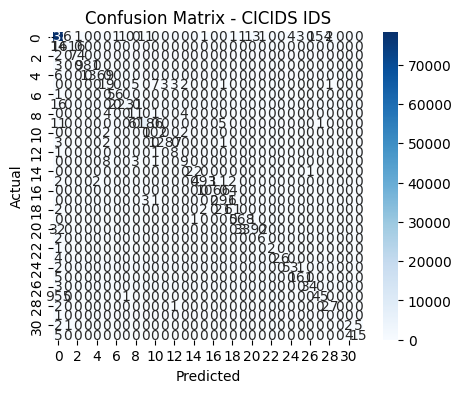

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - CICIDS IDS")
plt.show()

In [51]:
import joblib

joblib.dump(model, "cicids_rf_model.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [52]:
model = joblib.load("cicids_rf_model.pkl")
scaler = joblib.load("scaler.pkl")

In [53]:
new_sample = X_test[5].reshape(1, -1)
prediction = model.predict(new_sample)

print("Attack" if prediction[0] == 1 else "Normal")

Normal


In [54]:
import pandas as pd

feature_importance = pd.Series(
    model.feature_importances_,
    index=X_numeric.columns
).sort_values(ascending=False)

feature_importance.head(10)

,0
Avg Fwd Segment Size,0.045177
Fwd Packet Length Mean,0.044929
Init Fwd Win Bytes,0.044198
Fwd Packets Length Total,0.038959
Fwd Packet Length Max,0.037952
Subflow Fwd Bytes,0.031426
Bwd Packet Length Std,0.030322
Avg Bwd Segment Size,0.030292
Bwd Packet Length Max,0.027987
Fwd Header Length,0.027838


In [ ]:
#Qunatum part
